# Noise Reduction with Spectral Subtraction


Authors:-
- Aryan Gupta (230150003)
- Vibha Gupta (230150029)
- Tejas Deshmukh (230150027)
- Vaishnavi Agarwal (230150028)

## Table of Contents

1. [Introduction](#intro)  
2. [Setup & Dependencies](#libraries)  
3. [Configuration](#configuration)  
4. [Helper Functions](#helpfn)  
5. [Load & Denoise](#load)  
6. [Insert Dummy Data](#dummy)  
7. [Visualization](#visualise)  
9. [Save Output](#save)  
8. [External Test Case](#external)  
10. [Conclusion](#conclusion)

<a id="intro"></a>
## 1. Introduction

In this project we demonstrate **spectral subtraction**, a classical audio denoising method. The idea was given in the course `DA251 - Signals, Systems and Networks` by *Prof. Arghyadip Roy*.

- **Idea**: Estimate the noise spectrum from a short “noisy‐only” or "almost-silent" segment, subtract it from every frame of the recording in the frequency domain, then reconstruct via inverse STFT.
- **Applications**: Noise reduction, speech enhancement, audio restoration, preprocessing for other different pipelines.

<a id="libraries"></a>
## 2. Setup and Dependencies 

Run this command in the terminal.

```bash
pip install numpy librosa soundfile matplotlib scipy
```

### Importing libraries

In [13]:
# Import required libraries
import os
import numpy as np
np.complex = complex
# np.complex is a function, and complex is a class used by librosa to do the same thing, i.e, create complex numbers.
# It is just to keep librosa happy

import librosa        # audio I/O & processing
import librosa.display  # plotting
import soundfile as sf  # reading/writing WAV files
import matplotlib.pyplot as plt
from scipy.signal import stft, istft  # STFT operations

print('Libraries imported successfully!')

Libraries imported successfully!


### Audio Conversion Helper

Even if you have `.mp3`, `.flac`, or other formats in `audio_in/`, this function will convert them to WAV in `audio_wav/`.


In [14]:
from pathlib import Path

def convert_to_wav_dir(src_dir, dst_dir, sr=None):
    """
    Read every audio file in src_dir with librosa,
    write as WAV in dst_dir at its original (or specified) sr.
    """
    os.makedirs(dst_dir, exist_ok=True)
    for f in Path(src_dir).iterdir():
        if not f.is_file(): continue
        y, sr0 = librosa.load(str(f), sr=sr)  # sr=None preserves original
        out = Path(dst_dir)/f"{f.stem}.wav"
        sf.write(str(out), y, sr0)
        print(f"Converted {f.name} to {out}")
    print(f"Converted all files in {src_dir} to {dst_dir}")

<a id="configuration"></a>
## 3. Configuration

We define paths and STFT parameters here.

In [ ]:
# File paths
noisy_file = './noisy_sample.wav'                   # Input file
out_file   = './output/noisy_sample_denoised.wav'     # Output file

# sampling rate (in Hz)
sr = 44100

# STFT parameters
frame_len = 2048 # Number of samples that is analyzed as one data point. 2048 samples = 0.05 seconds at 44.1 kHz sampling rate
hop_len = 512    # how many samples you move forward after analyzing each frame. 512 samples = 0.0116 seconds at 44.1 kHz sampling rate

<a id="helpfn"></a>
## 4. Helper Functions

- **`extract_noise_profile`**: takes the first 0.5 s of `y`, computes its STFT, averages the magnitude across time to a 1D “noise spectrum.”  
- **`spectral_subtract`**: computes STFT of full signal, subtracts the noise spectrum from each frame’s magnitude (floored at zero), then rebuilds via ISTFT.  

In [16]:
def extract_noise_profile(y, sr, duration=0.5):
    """
    Estimate an average magnitude spectrum from the first duration seconds of y.
    """
    n = int(sr * duration)
    noise = y[:n]
    _, _, Zxx = stft(noise, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    return np.mean(np.abs(Zxx), axis=1)


def spectral_subtract(y, sr, noise_spec):
    """
    Subtract noise_spec from the full signal in magnitude domain, then invert.
    """
    _, _, Zxx = stft(y, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    mag, phase = np.abs(Zxx), np.angle(Zxx)
    sub_mag = np.maximum(mag - noise_spec[:, None], 0.0)
    _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,
                     nperseg=frame_len, noverlap=frame_len-hop_len,
                     boundary=None)
    # Ensure same length
    y_rec = librosa.util.fix_length(y_rec, size=len(y))
    return y_rec

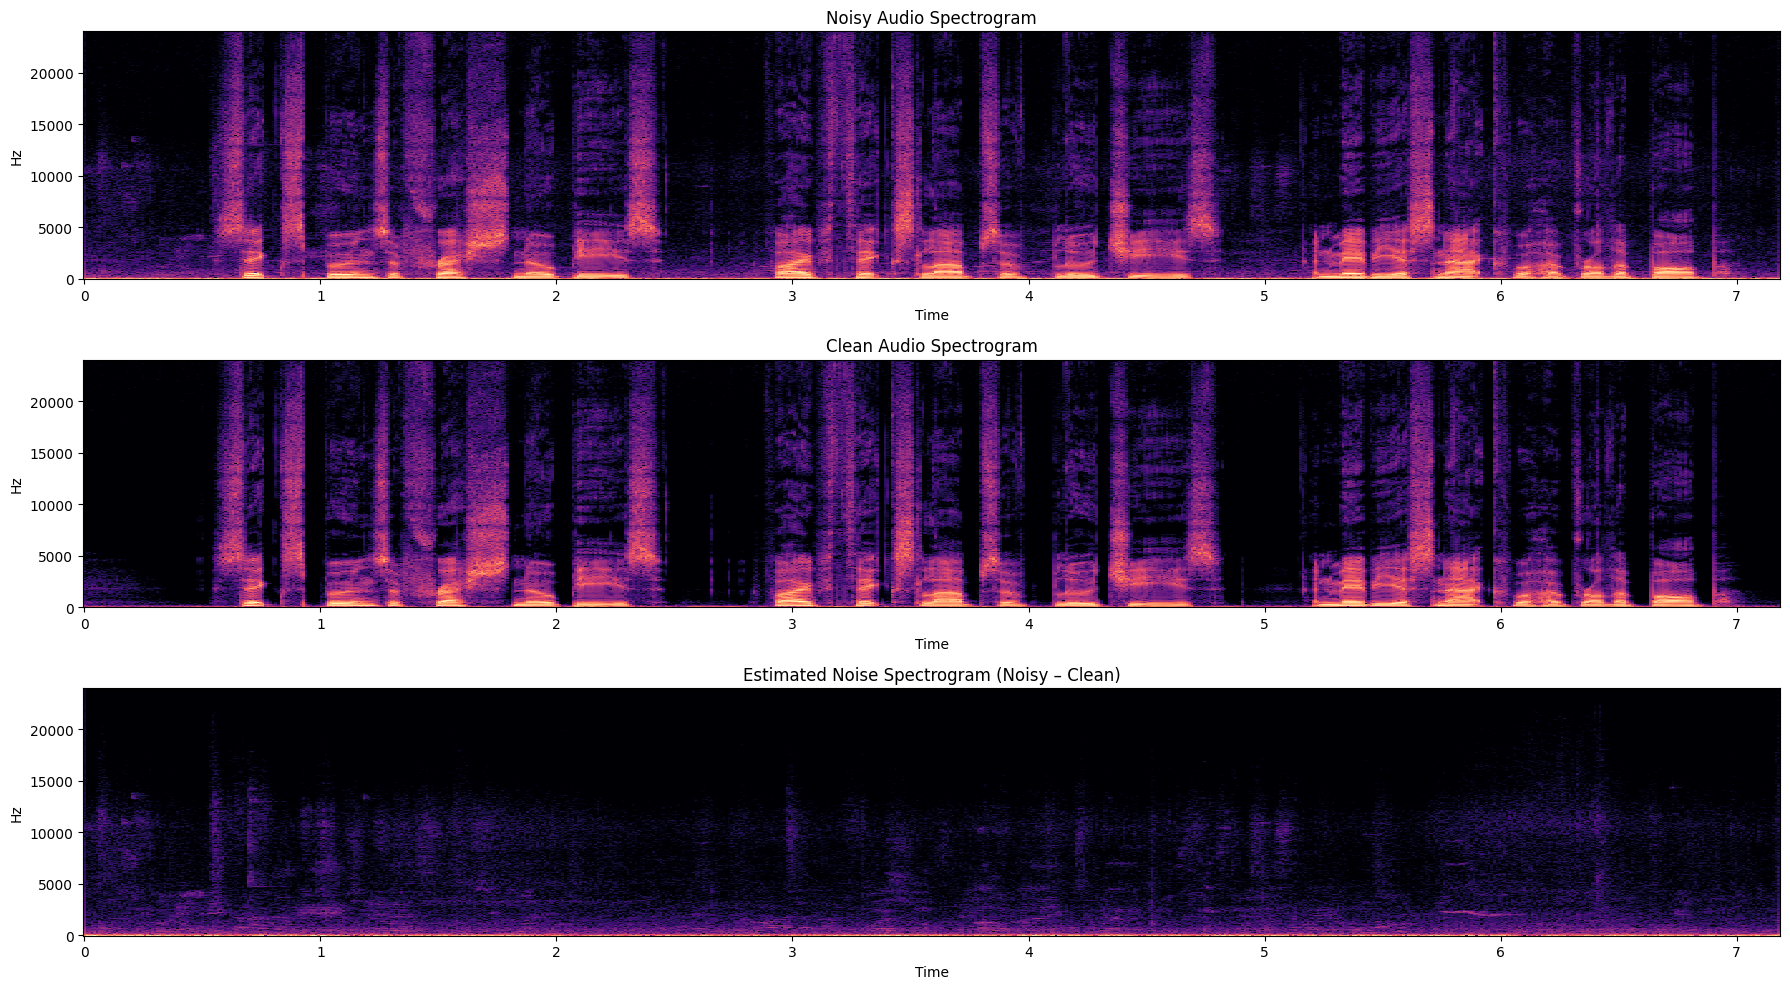

In [ ]:
import numpy as np
import librosa           # audio I/O & processing
import librosa.display   # spectrogram plotting
import matplotlib.pyplot as plt

# 1. Paths to your clean and noisy files
clean_path = './app2_data/clean/p232_003.wav'
noisy_path = './app2_data/noisy/p232_003.wav'

# 2. Load audio (preserve original sample rate)
y_clean, sr = librosa.load(clean_path, sr=None)            # :contentReference[oaicite:0]{index=0}
y_noisy, _  = librosa.load(noisy_path, sr=sr)              # :contentReference[oaicite:1]{index=1}

# 3. Trim to the same length via slicing
min_len   = min(len(y_clean), len(y_noisy))
y_clean   = y_clean[:min_len]                              # :contentReference[oaicite:2]{index=2}
y_noisy   = y_noisy[:min_len]

# 4. STFT parameters
n_fft       = 1024                                         # :contentReference[oaicite:3]{index=3}
hop_length  = 512

# 5. Compute STFTs (complex-valued)
clean_spec = librosa.stft(y_clean,  n_fft=n_fft, hop_length=hop_length)
noisy_spec = librosa.stft(y_noisy, n_fft=n_fft, hop_length=hop_length)

# 6. Estimate “noise spectrum” via simple subtraction in the complex domain
noise_spec = noisy_spec - clean_spec

# 7. Convert to magnitude for visualization
clean_mag = np.abs(clean_spec)                             # :contentReference[oaicite:4]{index=4}
noisy_mag = np.abs(noisy_spec)
noise_mag = np.abs(noise_spec)

# 8. Convert amplitudes to decibels
clean_db = librosa.amplitude_to_db(clean_mag, ref=np.max)  # :contentReference[oaicite:5]{index=5}
noisy_db = librosa.amplitude_to_db(noisy_mag, ref=np.max)
noise_db = librosa.amplitude_to_db(noise_mag, ref=np.max)

# 9. Plot the three spectrograms
plt.figure(figsize=(18, 10))

plt.subplot(3, 1, 1)
librosa.display.waveshow(noisy_db,
                         sr=sr,
                         hop_length=hop_length,
                         x_axis='time',
                         y_axis='linear')
plt.title("Noisy Audio Spectrogram")

plt.subplot(3, 1, 2)
librosa.display.waveshow(clean_db,
                         sr=sr,
                         hop_length=hop_length,
                         x_axis='time',
                         y_axis='linear')
plt.title("Clean Audio Spectrogram")

plt.subplot(3, 1, 3)
librosa.display.waveshow(noise_db,
                         sr=sr,
                         hop_length=hop_length,
                         x_axis='time',
                         y_axis='linear')
plt.title("Estimated Noise Spectrogram (Noisy – Clean)")

plt.tight_layout()
plt.show()                                                # :contentReference[oaicite:6]{index=6}


<a id="load"></a>
## 5. Load & Denoise

1. Load the noisy file.  
2. Estimate its noise profile from the first 0.5 s.  
3. Apply spectral subtraction.  


In [17]:
# Load noisy audio
y_noisy, sr = librosa.load(noisy_file, sr=None)
print(f"Loaded noisy audio: {noisy_file}, sr={sr}, duration={len(y_noisy)/sr:.2f}s")

# Estimate noise profile
noise_spec = extract_noise_profile(y_noisy, sr, duration=0.5)

# Apply spectral subtraction
y_denoised = spectral_subtract(y_noisy, sr, noise_spec)
print('Denoising complete!')

Loaded noisy audio: ./noisy_sample.wav, sr=48000, duration=9.30s
Denoising complete!


C:\Users\Aryan Gupta\AppData\Local\Temp\ipykernel_11148\4250752076.py:20: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,


`UserWarning: NOLA condition failed...`  
means the chosen window/hop don’t perfectly satisfy the overlap‑add invertibility criterion. SciPy still does a least‑squares reconstruction, but you get this warning. It’s harmless here.


<a id="visualise"></a>
## 6. Visualization

- **Waveforms** side‑by‑side  
- **Log‑spectrograms** for detailed frequency‑time view

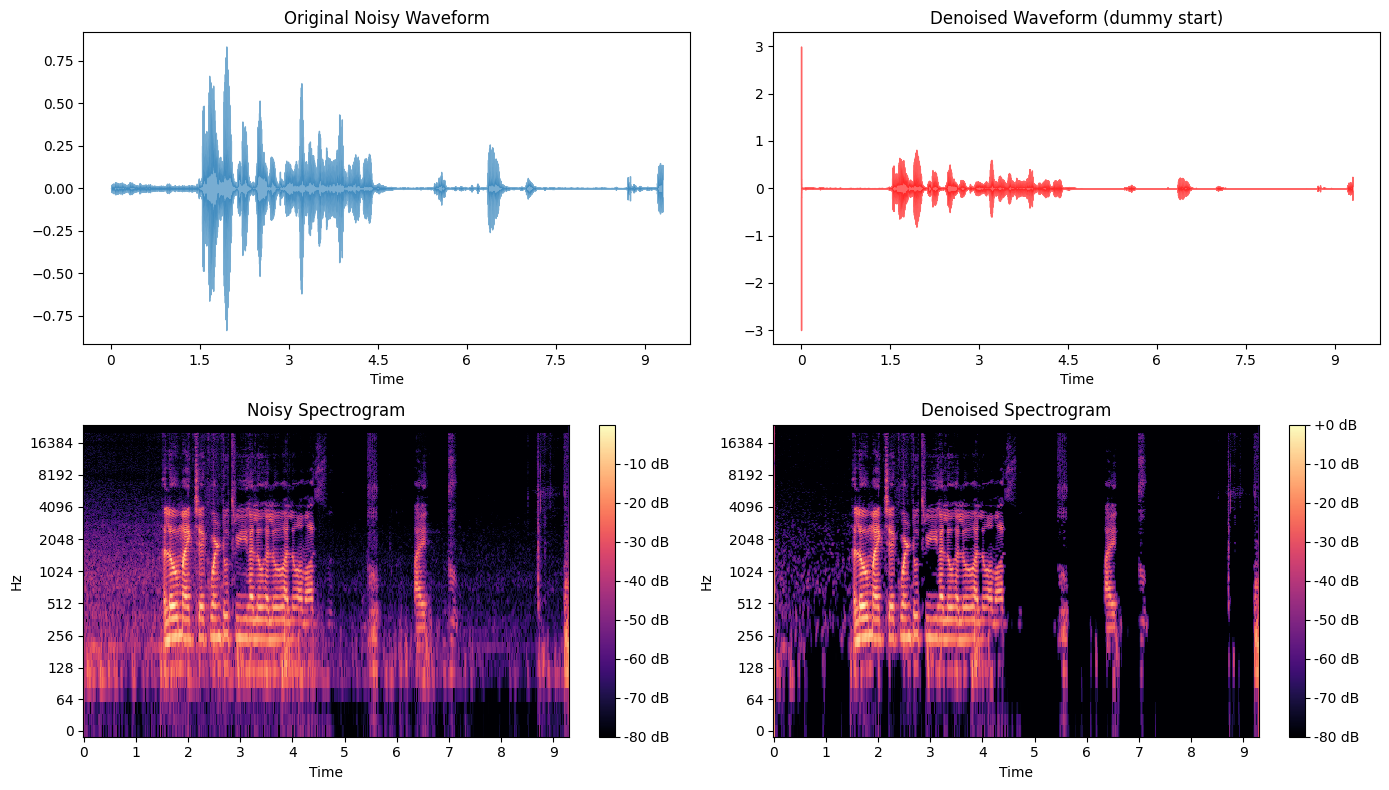

In [18]:
plt.figure(figsize=(14, 8))

# Waveforms
plt.subplot(2, 2, 1)
librosa.display.waveshow(y_noisy, sr=sr, alpha=0.6)
plt.title('Original Noisy Waveform')

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_denoised, sr=sr, color='r', alpha=0.6)
plt.title('Denoised Waveform (dummy start)')

# Spectrograms
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy, n_fft=frame_len, hop_length=hop_len)), ref=np.max)
D_denoised = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised, n_fft=frame_len, hop_length=hop_len)), ref=np.max)

plt.subplot(2, 2, 3)
librosa.display.specshow(D_noisy, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')

plt.subplot(2, 2, 4)
librosa.display.specshow(D_denoised, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Spectrogram')

plt.tight_layout()
plt.show()

As we can see, there is a noticeable dip at the start of the file. This occurs due to the application of the STFT — since we do not have any data at *t = 0*, the signal is still undergoing spectral subtraction, resulting in the observed dip.  
*Note: There is no actual error in the audio output at this point.*

---

To address this, we will add a small amount of dummy data at the beginning to counter the issue and produce a smoother plot.

<a id="dummy"></a>
## 7. Insert Dummy Data
This will counter the big spike that occurs due to STFT at *t=0*.

In [19]:
# Dummy data insertion
margin_ms = 5  # milliseconds to replace at start
n_dummy = int(margin_ms * 1e-3 * sr)

print(f'Dummy samples at start: {n_dummy}')

# Overwrite first n_dummy samples with zeros
y_denoised[:n_dummy] = 0
print(f'First {n_dummy} samples replaced with zeros for plotting.')

Dummy samples at start: 240
First 240 samples replaced with zeros for plotting.


### Revisualising

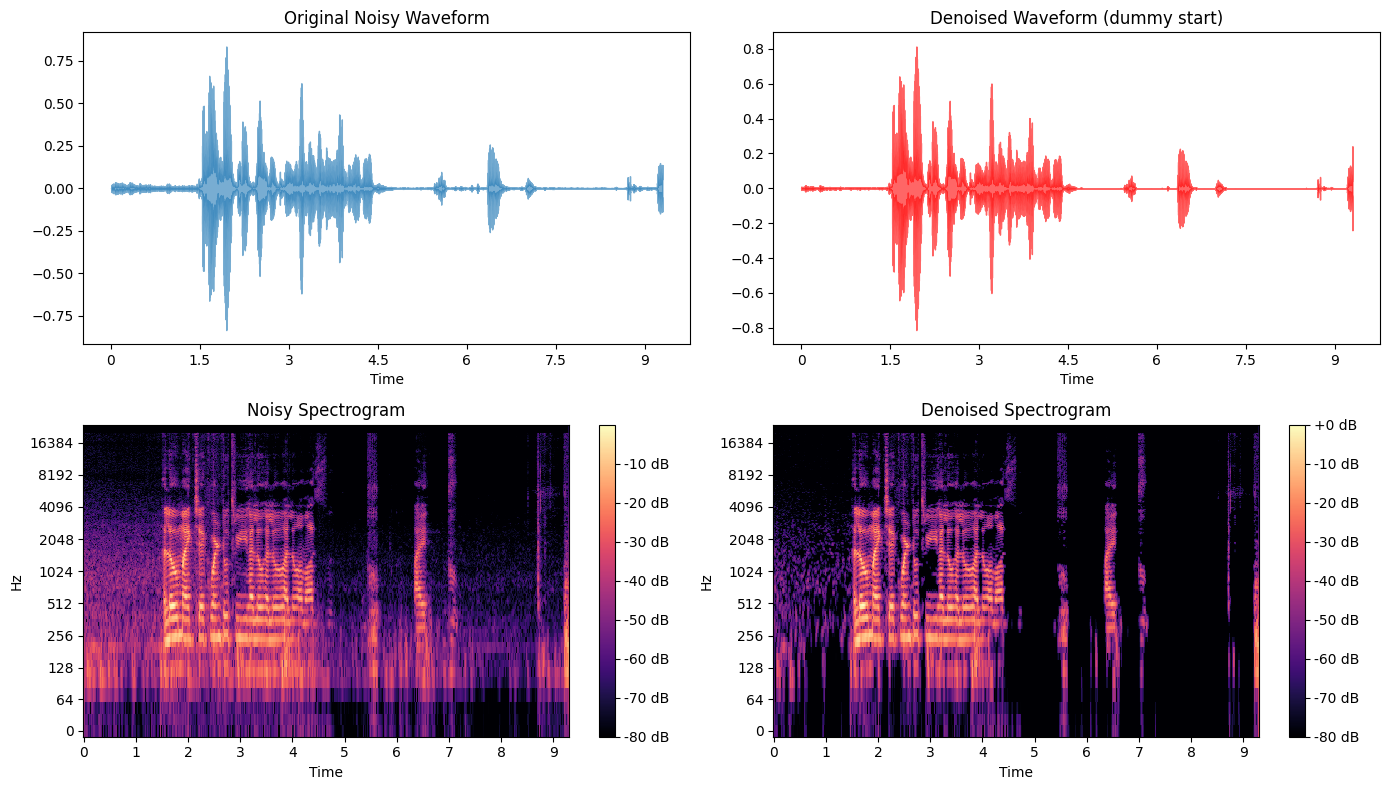

In [20]:
plt.figure(figsize=(14, 8))

# Waveforms
plt.subplot(2, 2, 1)
librosa.display.waveshow(y_noisy, sr=sr, alpha=0.6)
plt.title('Original Noisy Waveform')

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_denoised, sr=sr, color='r', alpha=0.6)
plt.title('Denoised Waveform (dummy start)')

# Spectrograms
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy, n_fft=frame_len, hop_length=hop_len)), ref=np.max)
D_denoised = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised, n_fft=frame_len, hop_length=hop_len)), ref=np.max)

plt.subplot(2, 2, 3)
librosa.display.specshow(D_noisy, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')

plt.subplot(2, 2, 4)
librosa.display.specshow(D_denoised, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Spectrogram')

plt.tight_layout()
plt.show()

<a id="save"></a>
## 8. Save Output

Let us save the final output as a *.wav* file. We can use the soundfile library to do the same.

In [21]:
# Create output directory
os.makedirs(os.path.dirname(out_file), exist_ok=True)

# Save denoised audio
sf.write(out_file, y_denoised, sr)
print(f"Denoised audio saved to: {out_file}")

Denoised audio saved to: ./output/noisy_sample_denoised.wav


<a id="external"></a>
## 9. External Test Case

Here we load one noisy/clean pair from an external dataset, denoise, and compare **SNR**.

### What is Signal‑to‑Noise Ratio (SNR)?

**Signal‑to‑Noise Ratio (SNR)** is a common metric used to quantify how much a signal (e.g., speech or music) stands out from background noise. It is defined as the ratio of the signal power to the noise power, usually expressed in decibels (dB):

$\mathrm{SNR} = 10 \log_{10}\!\biggl(\frac{\displaystyle\sum_{n} s[n]^2}{\displaystyle\sum_{n} (s[n] - \hat{s}[n])^2}\biggr)$

- $s[n]$ is the clean (reference) signal.  
- $\hat{s}[n]$ is the processed (denoised or noisy) signal.  
- A **higher SNR** indicates a cleaner signal (less noise), while a **lower SNR** means more noise relative to the signal.

However, you can also just give a listen to understand real world audio.

In [32]:
# Paths to two external files (noisy + its clean reference)
noisy_ext = './app2_data/noisy/p232_003.wav'
clean_ext = './app2_data/clean/p232_003.wav'
out_ext   = './output/external_denoised.wav'

# Load
y_n_e, sr_e = librosa.load(noisy_ext, sr=sr)
y_c_e, _    = librosa.load(clean_ext, sr=sr_e)

# Denoise
nspec_e = extract_noise_profile(y_n_e, sr_e)
y_d_e   = spectral_subtract(y_n_e, sr_e, nspec_e)
y_d_e[:n_dummy] = 0  # dummy start

# Simple SNR function
def compute_snr(clean, proc):
    c,a = clean[:len(proc)], proc[:len(clean)]
    noise = c - a
    return 10*np.log10(np.sum(c**2)/ (np.sum(noise**2)+1e-8))

snr_before = compute_snr(y_c_e, y_n_e)
snr_after  = compute_snr(y_c_e, y_d_e)

print(f"SNR before: {snr_before:.2f} dB")
print(f"SNR after:  {snr_after:.2f} dB")

# Save output
os.makedirs(os.path.dirname(out_ext), exist_ok=True)
sf.write(out_ext, y_d_e, sr_e)
print(f"Saved external test output to {out_ext}")


SNR before: 6.73 dB
SNR after:  17.53 dB
Saved external test output to ./output/external_denoised.wav


C:\Users\Aryan Gupta\AppData\Local\Temp\ipykernel_11148\4250752076.py:20: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,


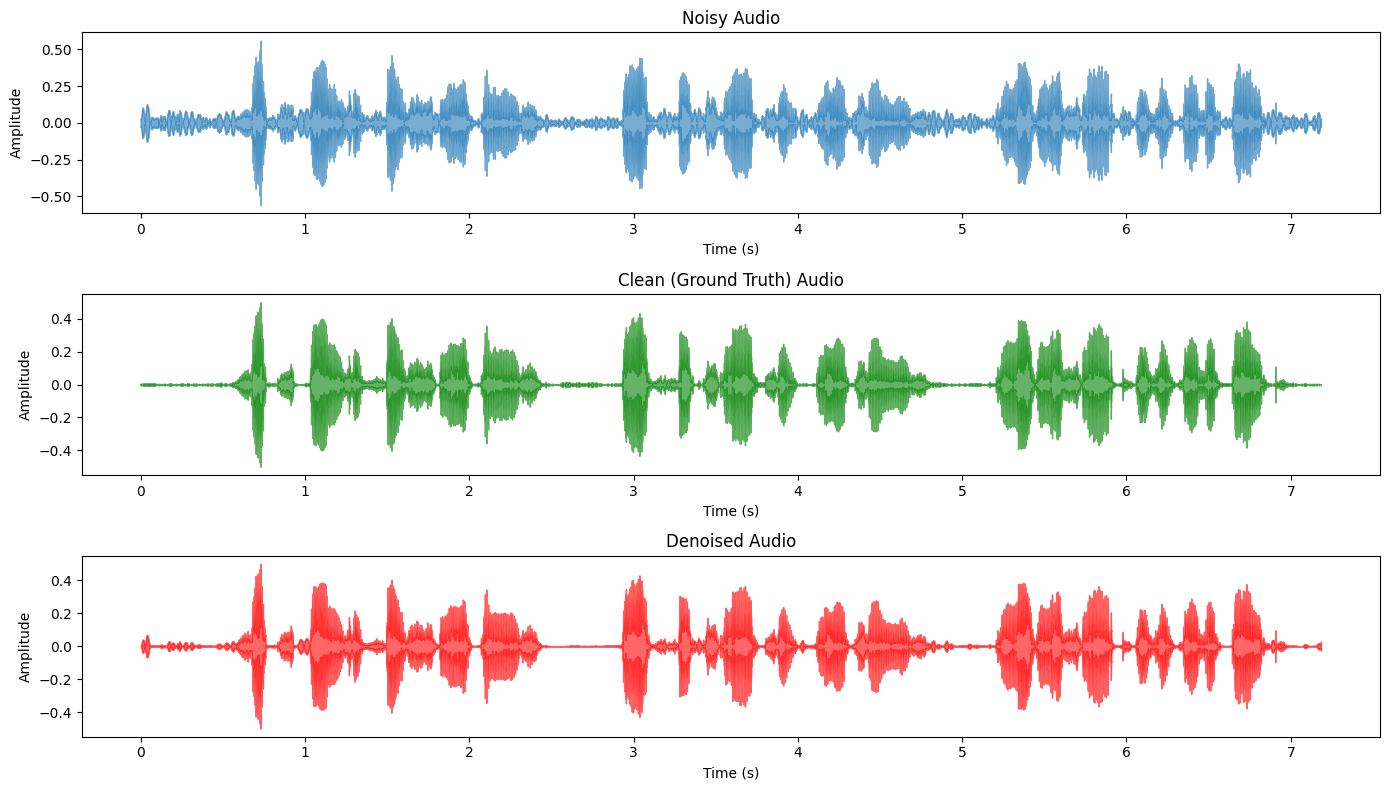

In [33]:
plt.figure(figsize=(14, 8))

# Noisy
plt.subplot(3, 1, 1)
librosa.display.waveshow(y_n_e, sr=sr_e, alpha=0.6)
plt.title('Noisy Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Clean
plt.subplot(3, 1, 2)
librosa.display.waveshow(y_c_e, sr=sr_e, color='g', alpha=0.6)
plt.title('Clean (Ground Truth) Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Denoised
plt.subplot(3, 1, 3)
librosa.display.waveshow(y_d_e, sr=sr_e, color='r', alpha=0.6)
plt.title('Denoised Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


<a id="conclusion"></a>
## 10. Conclusion

We have:
- Implemented a beginner‑friendly spectral subtraction pipeline  
- Added a dummy‑data trick to remove t=0 artifacts  
- Visualized both waveforms and spectrograms  
- Tested on an external noisy/clean pair and observed an SNR gain  

**Next steps:**  
- Experiment with **adaptive** noise estimation over time, i. e., changing noise sample from time to time
- Try different window shapes and hop sizes
- Wrap this into a batch pipeline for whole folders

Happy denoising! :)